In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


# Preprocess Data

#### Included with this lab are TSLA.csv, GOOGL.csv and DJI.csv files. Use Pandas to retrieve the dataset. 
#### Use only Open price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [2]:
torch.cuda.empty_cache()

tesla_stocks = pd.read_csv('TSLA.csv')

tesla_stocks.head()

Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

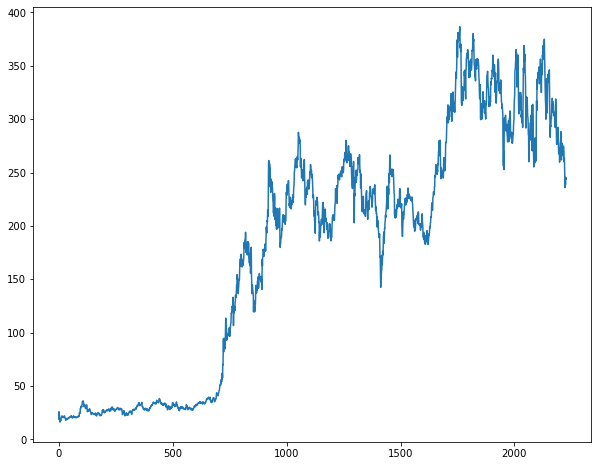

In [3]:
data_to_use_tesla = tesla_stocks['Open'].values
plt.figure(figsize=(10,8))
plt.plot(data_to_use_tesla)

## Normalize your data.

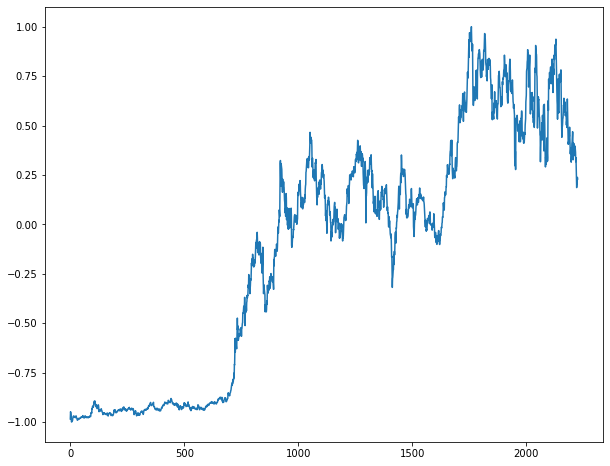

In [4]:
def norm_data(data):
    min_ = np.min(data)
    max_ = np.max(data)

    return (data-min_)/(max_-min_)*2-1

norm_tesla=norm_data(data_to_use_tesla)
plt.figure(figsize=(10,8))
plt.plot(norm_tesla)

## Split training, validation and testing data

In [5]:
period = 50     # use the first 30 data pints to predict the 31 st data point
last_n_days = 100
#val_ratio = 0

def custom_dataset(data, train_period=50, last_n_days_test=100):

    data_inp=np.zeros((len(data)-train_period-last_n_days_test,train_period))
    data_out=np.zeros((len(data)-train_period-last_n_days_test,1))

    test_out = np.zeros((last_n_days_test,1))

    for i in range(len(data)-train_period-last_n_days_test):
        data_inp[i,:]=data[i:i+train_period]
        data_out[i]=data[i+train_period]

    for i in range(last_n_days_test):
        test_out[i]=data[-last_n_days_test+i]

    return data_inp, data_out, test_out



train_inp, train_out, test_out=custom_dataset(norm_tesla, period, last_n_days)


## RNN Model

In [6]:
input_dim = 1
hidden_size = 128
num_layers = 2
out_size=1

bidirectional = False
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.hidden_dim=hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True, bidirectional=bidirectional,)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.rnn(x, (h0.detach()))
        
        out =self.act(self.linear(out[:,-1,:]))
        return out
        

rnn = CustomRNN(input_dim, hidden_size, out_size).to(device)
rnn

CustomRNN(
  (rnn): GRU(1, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (act): Tanh()
)

In [7]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-2)
loss_func = nn.MSELoss(reduction='mean')

for t in range(1001):
    hidden = None
    input_ = Variable(torch.Tensor(train_inp.reshape((*train_inp.shape,1)))).to(device)
    output_ = Variable(torch.Tensor(train_out)).to(device)
    
    pred = rnn(input_)
    
    predictions.append(pred.data.cpu().numpy())

    loss = loss_func(pred, output_)
    optimizer.zero_grad()
    
    if t%50==0:
        print(t, loss.data)
    loss.backward()
    optimizer.step()

0 tensor(0.3857, device='cuda:0')
50 tensor(0.0015, device='cuda:0')
100 tensor(0.0012, device='cuda:0')
150 tensor(0.0011, device='cuda:0')
200 tensor(0.0011, device='cuda:0')
250 tensor(0.0011, device='cuda:0')
300 tensor(0.0011, device='cuda:0')
350 tensor(0.0010, device='cuda:0')
400 tensor(0.0016, device='cuda:0')
450 tensor(0.0008, device='cuda:0')
500 tensor(0.0008, device='cuda:0')
550 tensor(0.0010, device='cuda:0')
600 tensor(0.0007, device='cuda:0')
650 tensor(0.0010, device='cuda:0')
700 tensor(0.0009, device='cuda:0')
750 tensor(0.0007, device='cuda:0')
800 tensor(0.0006, device='cuda:0')
850 tensor(0.0007, device='cuda:0')
900 tensor(0.0005, device='cuda:0')
950 tensor(0.0008, device='cuda:0')
1000 tensor(0.0005, device='cuda:0')


fig size: 72.0 DPI, size in inches [16.  8.]


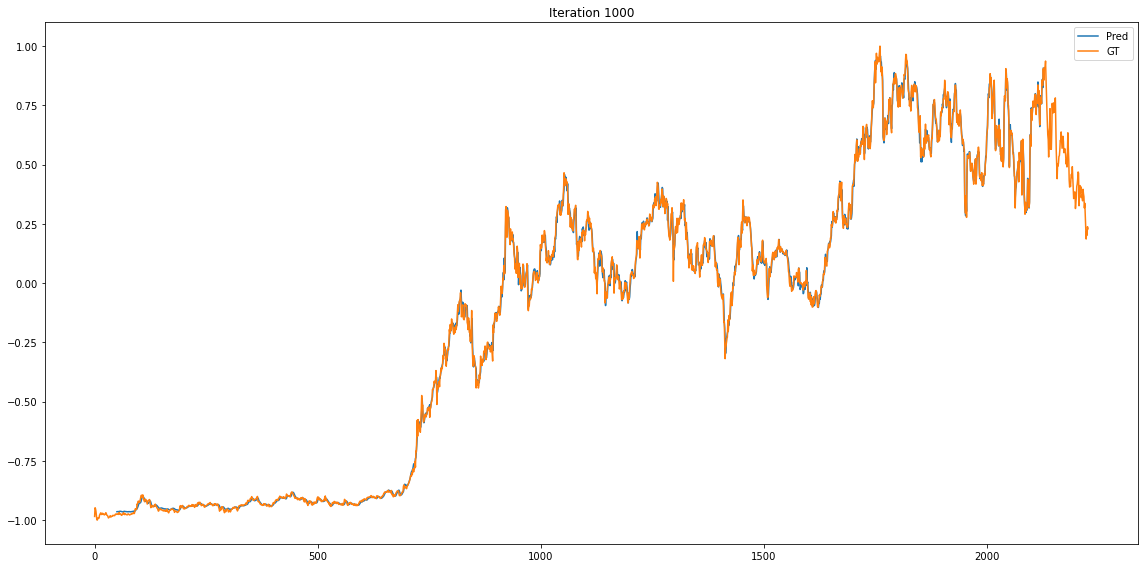

In [8]:
from matplotlib import animation, rc 

fig, ax = plt.subplots(figsize=(16, 8))
fig.set_tight_layout(True)
x=np.arange(len(norm_tesla))
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(x[period:-last_n_days],predictions[i][:,0].T, label='Pred')
    ax.plot(norm_tesla, label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = animation.FuncAnimation(fig, update, frames=range(0, len(predictions), 50), interval=20)
rc('animation', html='jshtml')
anim

## Testing code

tensor(0.0537, device='cuda:0')


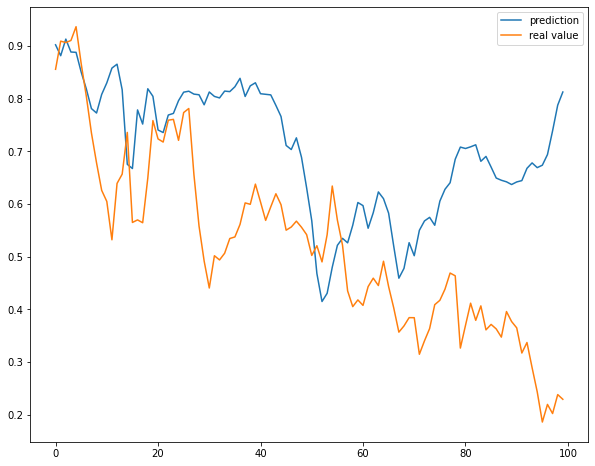

In [9]:
def pred_test(period,last_n_days):
    last=torch.Tensor(predictions[-1][-period:].reshape(1,-1,1)).to(device)
    new_last= last
    pred=np.zeros(last_n_days)
    for i in range(last_n_days):
        with torch.no_grad():
            test = rnn(new_last)
            pred[i]=test[0,0].cpu().numpy()
            last=new_last
            new_last= torch.zeros(1,period,1).to(device)
            new_last[0,:-1] = last[0,1:]
            new_last[0,-1]=test[0]
    return pred
pred = pred_test(period,last_n_days)
test_loss = loss_func(Variable(torch.Tensor(pred.reshape(-1,1))).to(device),Variable(torch.Tensor(test_out)).to(device))
print(test_loss)

plt.figure(figsize=(10,8))
plt.plot(pred,label='prediction')
plt.plot(test_out,label='real value')
plt.legend()
plt.show()

# Questions to answer 
1. 
    * The RNN is of type GRU
    * Input dim=1, hidden dim= 128, num_layer= 2. Lookback period = 50 (so the 51 st will be predicted)
    * Tanh nonlinearity
    * FC layer of 128x1
    * Bi-directional = False, hidden state is detached
    * Training epoch =1001
    * Learning rate = 0.01
2.  A. Tesla prediction 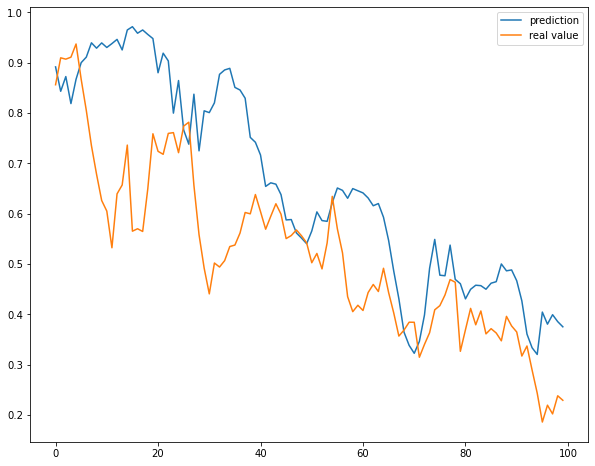
    B. Google prediction 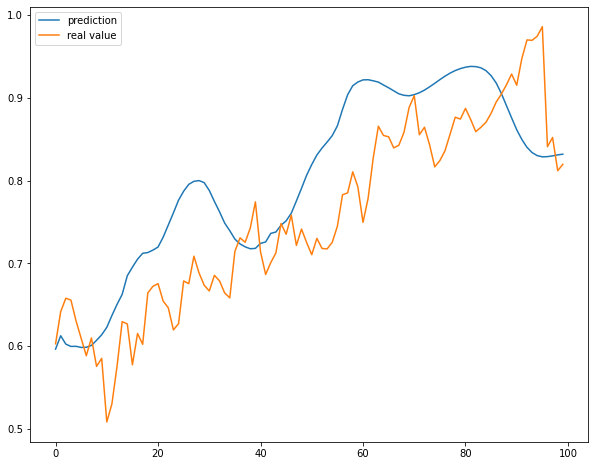
    C. Dow Jones prediction 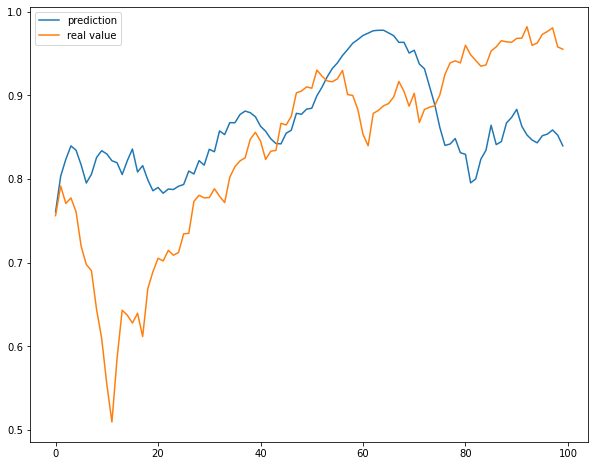


3. My RNN model struggles with fitting the first few hundreds of data and the last few hundreds of data for a long time. However, it is pretty good at fitting the data in the middle. And I see no improvement after I increase or decrease the batch size, increase epoch numbers, and increase hidden layer size. After all, the cause is found to be normalization of data. The data is normalized by first minus mean value and divide by strand deviation. However, this makes the magnitude of the first few and last few hundreds of data bigger than 1. After using min-max normalization on a [-1,1] interval, the model does well at fitting all the training data. 

Also I notice that when defining the model it is important to detach the hidden state during forward pass. Use gru(x, h0.detach())), where h0 is a torch zeros tensor. Without doing it, the model struggles fitting the data with minor fluctuations and the model is very insensitive or less accurate. One prediction on last 100 days looks like this:  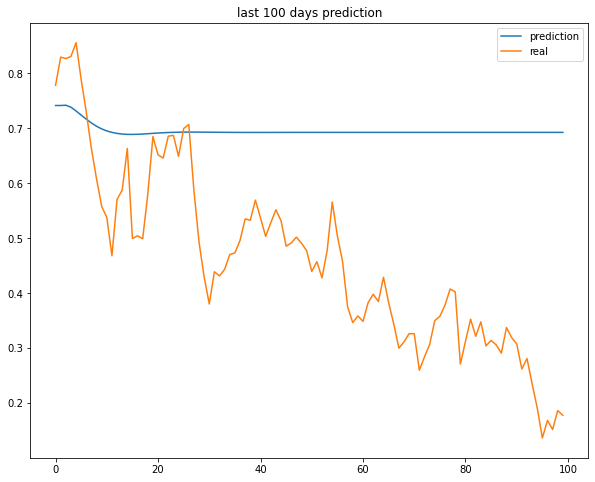 After detaching, I see a huge improvement. 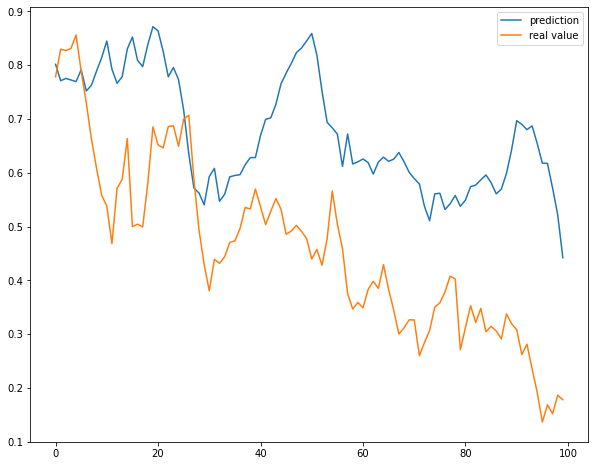 This is due to the reason of vanishing/exploding gradients, probably seen a lot in RNNs. The detaching keeps the hidden state but we don't compute the gradients. 

Another issue is that for Tesla and Google, I use lookback period of 50 data points and hidden size 128. The prediction for last 100 days is fairly good for these two stocks. However, the same setup doesn't work for Dow Jones. And the prediction for last 100 days becomes a horizontal line. I think the main reason is the need for more lookback period and hidden size, because Dow Jones' data size is 4 times bigger than the other two stocks. It has 8k+ data points, so need a more complex RNN model. To address this, I ignore the first 5000 data points, so the size of stock data is reduced to 3k+. Then I increase the lookback period. Finally, the prediction seems to be closer to real value.


# Prediction on Google stock price



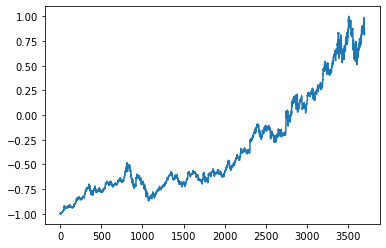

In [10]:
torch.cuda.empty_cache()

google_stocks = pd.read_csv('GOOGL.csv')

data_to_use_google = google_stocks['Open'].values

norm_google=norm_data(data_to_use_google)
plt.plot(norm_google)

In [11]:
period = 50     # use the first 50 data pints to predict the 51 st data point
last_n_days = 100
#val_ratio = 0

def custom_dataset(data, train_period=50, last_n_days_test=100):

    data_inp=np.zeros((len(data)-train_period-last_n_days_test,train_period))
    data_out=np.zeros((len(data)-train_period-last_n_days_test,1))

    test_out = np.zeros((last_n_days_test,1))

    for i in range(len(data)-train_period-last_n_days_test):
        data_inp[i,:]=data[i:i+train_period]
        data_out[i]=data[i+train_period]

    for i in range(last_n_days_test):
        test_out[i]=data[-last_n_days_test+i]

    return data_inp, data_out, test_out



train_inp, train_out, test_out=custom_dataset(norm_google, period, last_n_days)


In [12]:
input_dim = 1
hidden_size = 128
num_layers = 2
out_size=1

bidirectional = False
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.hidden_dim=hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True, bidirectional=bidirectional,)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.rnn(x, (h0.detach()))
        
        out =self.act(self.linear(out[:,-1,:]))
        return out
        

rnn = CustomRNN(input_dim, hidden_size, out_size).to(device)
rnn

CustomRNN(
  (rnn): GRU(1, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (act): Tanh()
)

In [13]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-2)
loss_func = nn.MSELoss(reduction='mean')

for t in range(1001):
    hidden = None
    input_ = Variable(torch.Tensor(train_inp.reshape((*train_inp.shape,1)))).to(device)
    output_ = Variable(torch.Tensor(train_out)).to(device)
    
    pred = rnn(input_)
    
    predictions.append(pred.data.cpu().numpy())

    loss = loss_func(pred, output_)
    optimizer.zero_grad()
    
    if t%100==0:
        print(t, loss.data)
    loss.backward()
    optimizer.step()

0 tensor(0.4590, device='cuda:0')
100 tensor(0.0003, device='cuda:0')
200 tensor(0.0002, device='cuda:0')
300 tensor(0.0002, device='cuda:0')
400 tensor(0.0002, device='cuda:0')
500 tensor(0.0002, device='cuda:0')
600 tensor(0.0002, device='cuda:0')
700 tensor(0.0002, device='cuda:0')
800 tensor(0.0002, device='cuda:0')
900 tensor(0.0003, device='cuda:0')
1000 tensor(0.0002, device='cuda:0')


fig size: 72.0 DPI, size in inches [16.  8.]


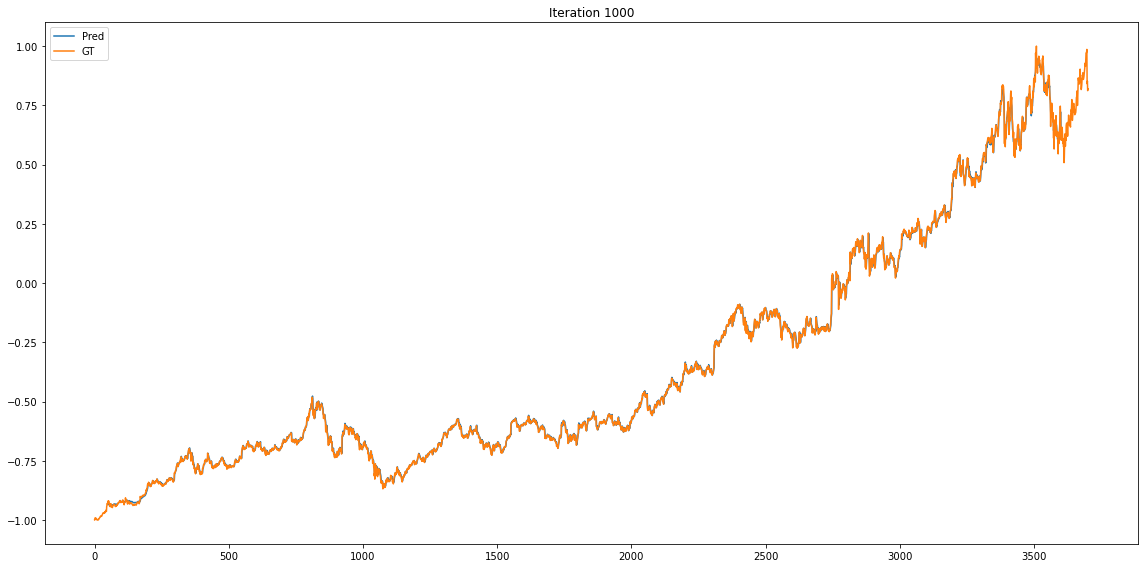

In [14]:
from matplotlib import animation, rc 

fig, ax = plt.subplots(figsize=(16, 8))
fig.set_tight_layout(True)
x=np.arange(len(norm_google))
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(x[period:-last_n_days],predictions[i][:,0].T, label='Pred')
    ax.plot(norm_google, label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = animation.FuncAnimation(fig, update, frames=range(0, len(predictions), 50), interval=20)
rc('animation', html='jshtml')
anim

tensor(0.0261, device='cuda:0')


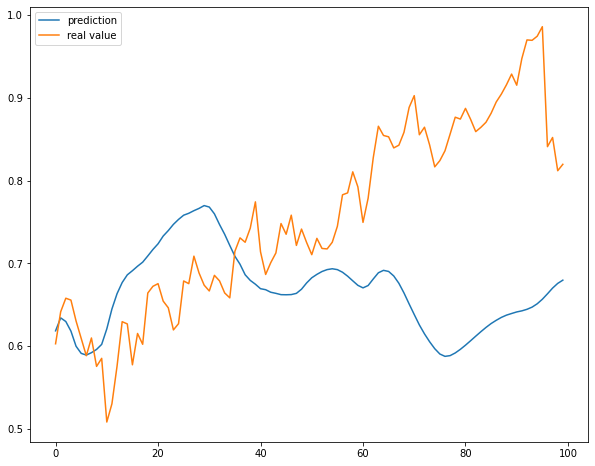

In [15]:
def pred_test(period,last_n_days):
    last=torch.Tensor(predictions[-1][-period:].reshape(1,-1,1)).to(device)
    new_last= last
    pred=np.zeros(last_n_days)
    for i in range(last_n_days):
        with torch.no_grad():
            test = rnn(new_last)
            pred[i]=test[0,0].cpu().numpy()
            last=new_last
            new_last= torch.zeros(1,period,1).to(device)
            new_last[0,:-1] = last[0,1:]
            new_last[0,-1]=test[0]
    return pred
pred = pred_test(period,last_n_days)
test_loss = loss_func(Variable(torch.Tensor(pred.reshape(-1,1))).to(device),Variable(torch.Tensor(test_out)).to(device))
print(test_loss)

plt.figure(figsize=(10,8))
plt.plot(pred,label='prediction')
plt.plot(test_out,label='real value')
plt.legend()
plt.show()

# Prediction on Dow Jones

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


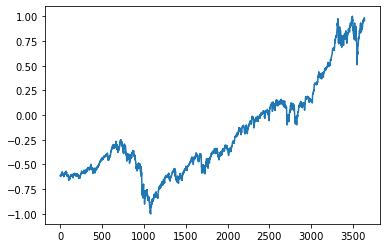

In [16]:
torch.cuda.empty_cache()

DJ_stocks = pd.read_csv('DJI.csv')

data_to_use_DJ = DJ_stocks['Open'].values
data_to_use_DJ =data_to_use_DJ[5000:]
norm_DJ=norm_data(data_to_use_DJ)
plt.plot(norm_DJ)

In [17]:
period = 80     # use the first 80 data pints to predict the 81 st data point
last_n_days = 100
#val_ratio = 0

def custom_dataset(data, train_period=50, last_n_days_test=100):

    data_inp=np.zeros((len(data)-train_period-last_n_days_test,train_period))
    data_out=np.zeros((len(data)-train_period-last_n_days_test,1))

    test_out = np.zeros((last_n_days_test,1))

    for i in range(len(data)-train_period-last_n_days_test):
        data_inp[i,:]=data[i:i+train_period]
        data_out[i]=data[i+train_period]

    for i in range(last_n_days_test):
        test_out[i]=data[-last_n_days_test+i]

    return data_inp, data_out, test_out



train_inp, train_out, test_out=custom_dataset(norm_DJ, period, last_n_days)


In [18]:
input_dim = 1
hidden_size = 128
num_layers = 2
out_size=1

bidirectional = False
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.hidden_dim=hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True, bidirectional=bidirectional,)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.rnn(x, (h0.detach()))
        
        out =self.act(self.linear(out[:,-1,:]))
        return out
        

rnn = CustomRNN(input_dim, hidden_size, out_size).to(device)
rnn

CustomRNN(
  (rnn): GRU(1, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (act): Tanh()
)

In [ ]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-2)
loss_func = nn.MSELoss(reduction='mean')

for t in range(1501):
    hidden = None
    input_ = Variable(torch.Tensor(train_inp.reshape((*train_inp.shape,1)))).to(device)
    output_ = Variable(torch.Tensor(train_out)).to(device)
    
    pred = rnn(input_)
    
    predictions.append(pred.data.cpu().numpy())

    loss = loss_func(pred, output_)
    optimizer.zero_grad()
    
    if t%50==0:
        print(t, loss.data)
    loss.backward()
    optimizer.step()

0 tensor(0.2533, device='cuda:0')
50 tensor(0.0011, device='cuda:0')
100 tensor(0.0003, device='cuda:0')
150 tensor(0.0002, device='cuda:0')
200 tensor(0.0002, device='cuda:0')
250 tensor(0.0002, device='cuda:0')
300 tensor(0.0002, device='cuda:0')
350 tensor(0.0002, device='cuda:0')


fig size: 72.0 DPI, size in inches [16.  8.]


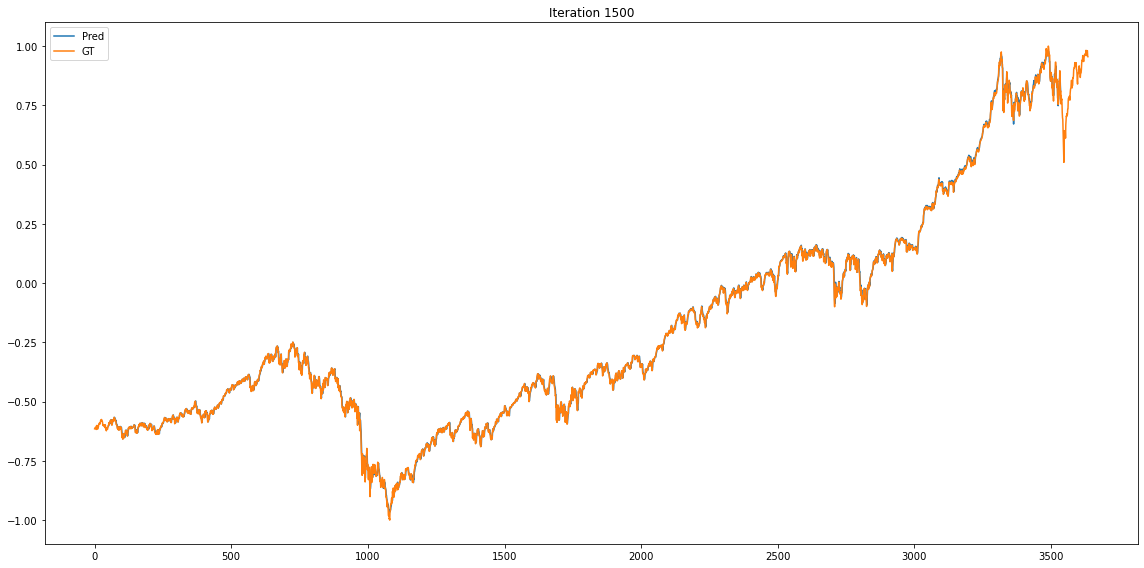

In [26]:
from matplotlib import animation, rc 

fig, ax = plt.subplots(figsize=(16, 8))
fig.set_tight_layout(True)
x=np.arange(len(norm_DJ))
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(i):
    label = 'Iteration {0}'.format(i)
    ax.cla()
    ax.plot(x[period:-last_n_days],predictions[i][:,0].T, label='Pred')
    ax.plot(norm_DJ, label='GT')
    ax.legend()
    ax.set_title(label)
 

anim = animation.FuncAnimation(fig, update, frames=range(0, len(predictions), 50), interval=20)
rc('animation', html='jshtml')
anim

tensor(0.0105, device='cuda:0')


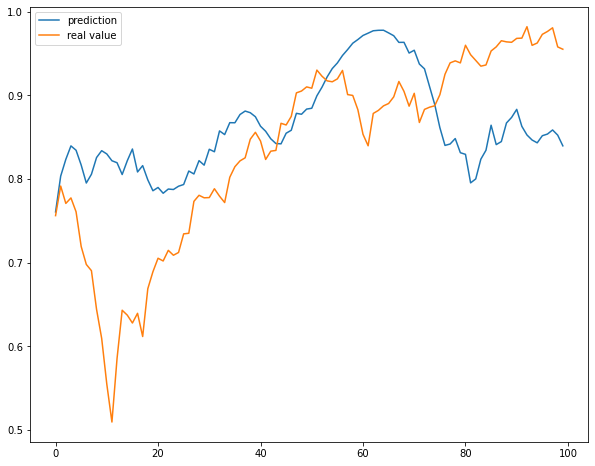

In [23]:
def pred_test(period,last_n_days):
    last=torch.Tensor(predictions[-1][-period:].reshape(1,-1,1)).to(device)
    new_last= last
    pred=np.zeros(last_n_days)
    for i in range(last_n_days):
        with torch.no_grad():
            test = rnn(new_last)
            pred[i]=test[0,0].cpu().numpy()
            last=new_last
            new_last= torch.zeros(1,period,1).to(device)
            new_last[0,:-1] = last[0,1:]
            new_last[0,-1]=test[0]
    return pred
pred = pred_test(period,last_n_days)
test_loss = loss_func(Variable(torch.Tensor(pred.reshape(-1,1))).to(device),Variable(torch.Tensor(test_out)).to(device))
print(test_loss)

plt.figure(figsize=(10,8))
plt.plot(pred,label='prediction')
plt.plot(test_out,label='real value')
plt.legend()
plt.show()